In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os

# Define the URL
url = "https://data.ceda.ac.uk/badc/ukmo-hadobs/data/insitu/MOHC/HadOBS/HadUK-Grid/v1.2.0.ceda/60km"

# Send an HTTP GET request to the URL
response = requests.get(url)

# Parse the HTML content of the webpage
soup = BeautifulSoup(response.text, "html.parser")

# Create a directory to save the downloaded files
if not os.path.exists("downloaded_files"):
    os.makedirs("downloaded_files")

# Find all file links that end with .nc
file_links = [link.get("href") for link in soup.find_all("a") if link.get("href").endswith(".nc")]

# Iterate through the file links and download the files
for file_link in file_links:
    file_url = f"{url}/{file_link}"
    file_name = os.path.join("downloaded_files", file_link)
    
    response = requests.get(file_url)
    
    with open(file_name, "wb") as file:
        file.write(response.content)

# Create a dataframe with the downloaded file information
data = pd.DataFrame({
    "Filename": file_links,
    "File URL": [f"{url}/{file_link}" for file_link in file_links]
})


print(data)



Empty DataFrame
Columns: [Filename, File URL]
Index: []


In [2]:
import xarray as xr


# Open the netcdf file using xarray
ds = xr.open_dataset('sfcWind_hadukgrid_uk_1km_ann-20y_198101-200012.nc')

# Convert the data to a pandas dataframe
df = ds.to_dataframe()

# reset the index to a simpler index
df.reset_index(inplace=True)


print(df.head())


df.to_csv('wind_data_met.csv', index=False)

        time  projection_y_coordinate  projection_x_coordinate  bnds  sfcWind  \
0 1981-07-01                -199500.0                -199500.0     0      NaN   
1 1981-07-01                -199500.0                -199500.0     1      NaN   
2 1981-07-01                -199500.0                -198500.0     0      NaN   
3 1981-07-01                -199500.0                -198500.0     1      NaN   
4 1981-07-01                -199500.0                -197500.0     0      NaN   

   transverse_mercator  time_bnds  projection_y_coordinate_bnds  \
0          -2147483647 1981-01-01                     -200000.0   
1          -2147483647 2000-12-31                     -199000.0   
2          -2147483647 1981-01-01                     -200000.0   
3          -2147483647 2000-12-31                     -199000.0   
4          -2147483647 1981-01-01                     -200000.0   

   projection_x_coordinate_bnds   latitude  longitude  
0                     -200000.0  47.824377 -10.012910 

In [3]:
df['sfcWind'][100]

nan

In [4]:
print(df.tail())

              time  projection_y_coordinate  projection_x_coordinate  bnds  \
2609995 1981-07-01                1249500.0                 697500.0     1   
2609996 1981-07-01                1249500.0                 698500.0     0   
2609997 1981-07-01                1249500.0                 698500.0     1   
2609998 1981-07-01                1249500.0                 699500.0     0   
2609999 1981-07-01                1249500.0                 699500.0     1   

         sfcWind  transverse_mercator  time_bnds  \
2609995      NaN          -2147483647 2000-12-31   
2609996      NaN          -2147483647 1981-01-01   
2609997      NaN          -2147483647 2000-12-31   
2609998      NaN          -2147483647 1981-01-01   
2609999      NaN          -2147483647 2000-12-31   

         projection_y_coordinate_bnds  projection_x_coordinate_bnds  \
2609995                     1250000.0                      698000.0   
2609996                     1249000.0                      698000.0   
26099

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Embedding, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, GlobalMaxPool1D
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import scipy.stats as stats
import os
import sys

In [2]:
wind_speed = pd.read_csv("uk 2019-01-01 to 2021-09-26.csv")

In [3]:
wind_speed.shape

(1000, 33)

In [4]:
wind_speed.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,uk,2019-01-01,11.1,6.5,8.8,11.1,4.3,7.3,4.4,73.9,...,1.4,1,NaN,2019-01-01T08:06:15,2019-01-01T16:01:50,0.84,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"03769099999,03680099999,D5621,03672099999,0378..."
1,uk,2019-01-02,6.6,5.1,5.8,5.2,3.1,4.0,0.5,68.8,...,1.6,1,NaN,2019-01-02T08:06:09,2019-01-02T16:02:54,0.88,Overcast,Cloudy skies throughout the day.,cloudy,"03769099999,03680099999,D5621,03672099999,0378..."
2,uk,2019-01-03,5.6,4.0,5.1,5.1,3.2,4.4,-0.7,66.3,...,1.3,1,NaN,2019-01-03T08:05:59,2019-01-03T16:04:00,0.91,Overcast,Cloudy skies throughout the day.,cloudy,"03769099999,03680099999,D5621,03660099999,0367..."
3,uk,2019-01-04,5.0,2.5,3.6,4.1,1.1,2.3,-1.4,69.8,...,2.4,2,NaN,2019-01-04T08:05:45,2019-01-04T16:05:09,0.95,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"03769099999,03680099999,D5621,03672099999,0378..."
4,uk,2019-01-05,6.1,4.0,5.1,4.7,1.4,3.1,0.8,73.8,...,0.6,0,NaN,2019-01-05T08:05:29,2019-01-05T16:06:21,0.98,Overcast,Cloudy skies throughout the day.,cloudy,"03769099999,03680099999,D5621,03672099999,0378..."


In [5]:
print(wind_speed['sealevelpressure'].unique())
print(wind_speed['windgust'].unique())
print(wind_speed['icon'].unique())

[1035.6 1043.  1043.2 1042.3 1039.1 1036.8 1032.3 1028.1 1029.6 1030.6
 1030.2 1023.1 1014.3 1020.3 1019.5 1006.1 1011.3 1016.5 1010.  1017.9
 1021.3 1002.1 1002.6 1011.7 1014.   991.8 1005.8 1000.   995.8  991.5
  987.7 1006.8 1023.  1018.7 1023.2 1006.2  999.4 1000.5  997.8 1023.4
 1033.3 1033.2 1032.  1027.1 1022.8 1016.1 1015.5 1018.8 1020.1 1026.4
 1034.6 1033.9 1036.2 1032.5 1024.9 1016.  1018.2 1010.2  998.4  994.4
 1002.5  989.9  992.6 1009.8 1012.2 1009.1 1022.9 1007.1 1008.  1007.3
 1005.3 1020.5 1027.4 1033.  1028.9 1031.4 1031.3 1032.6 1034.2 1035.1
 1029.1 1024.3 1019.6 1004.9  999.   995.2 1001.8 1005.4 1008.1 1010.9
 1013.9 1019.3 1025.7 1027.  1025.6 1020.4 1015.1 1019.4 1020.6 1006.5
  997.5  994.2  999.2 1009.  1009.6 1019.7 1025.9 1024.6 1018.5 1014.7
 1019.1 1025.8 1022.1 1014.6  995.   997.1 1008.6 1039.5 1026.7 1009.4
 1006.7 1012.5 1017.  1013.7 1010.6 1012.3 1020.8 1023.7 1010.4 1012.4
 1006.6 1005.9 1010.1 1003.  1015.  1011.4 1009.9 1012.8 1016.6 1017.7
 1014.

In [7]:
wind_speed['datetime'] =pd.to_datetime(wind_speed['datetime'])
wind_speed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   name              1000 non-null   object        
 1   datetime          1000 non-null   datetime64[ns]
 2   tempmax           1000 non-null   float64       
 3   tempmin           1000 non-null   float64       
 4   temp              1000 non-null   float64       
 5   feelslikemax      1000 non-null   float64       
 6   feelslikemin      1000 non-null   float64       
 7   feelslike         1000 non-null   float64       
 8   dew               1000 non-null   float64       
 9   humidity          1000 non-null   float64       
 10  precip            1000 non-null   float64       
 11  precipprob        1000 non-null   int64         
 12  precipcover       1000 non-null   float64       
 13  preciptype        583 non-null    object        
 14  snow              1000 no

In [8]:
#wind_speed['windgust']= wind_speed['windgust'].fillna(0)
wind_speed.isna().sum()

name                   0
datetime               0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
precipcover            0
preciptype           417
snow                   0
snowdepth              0
windgust             497
windspeed              0
winddir                0
sealevelpressure       1
cloudcover             0
visibility             0
solarradiation         0
solarenergy            0
uvindex                0
severerisk          1000
sunrise                0
sunset                 0
moonphase              0
conditions             0
description            0
icon                   0
stations               0
dtype: int64

Text(0.5, 1.0, 'daily average wind speed')

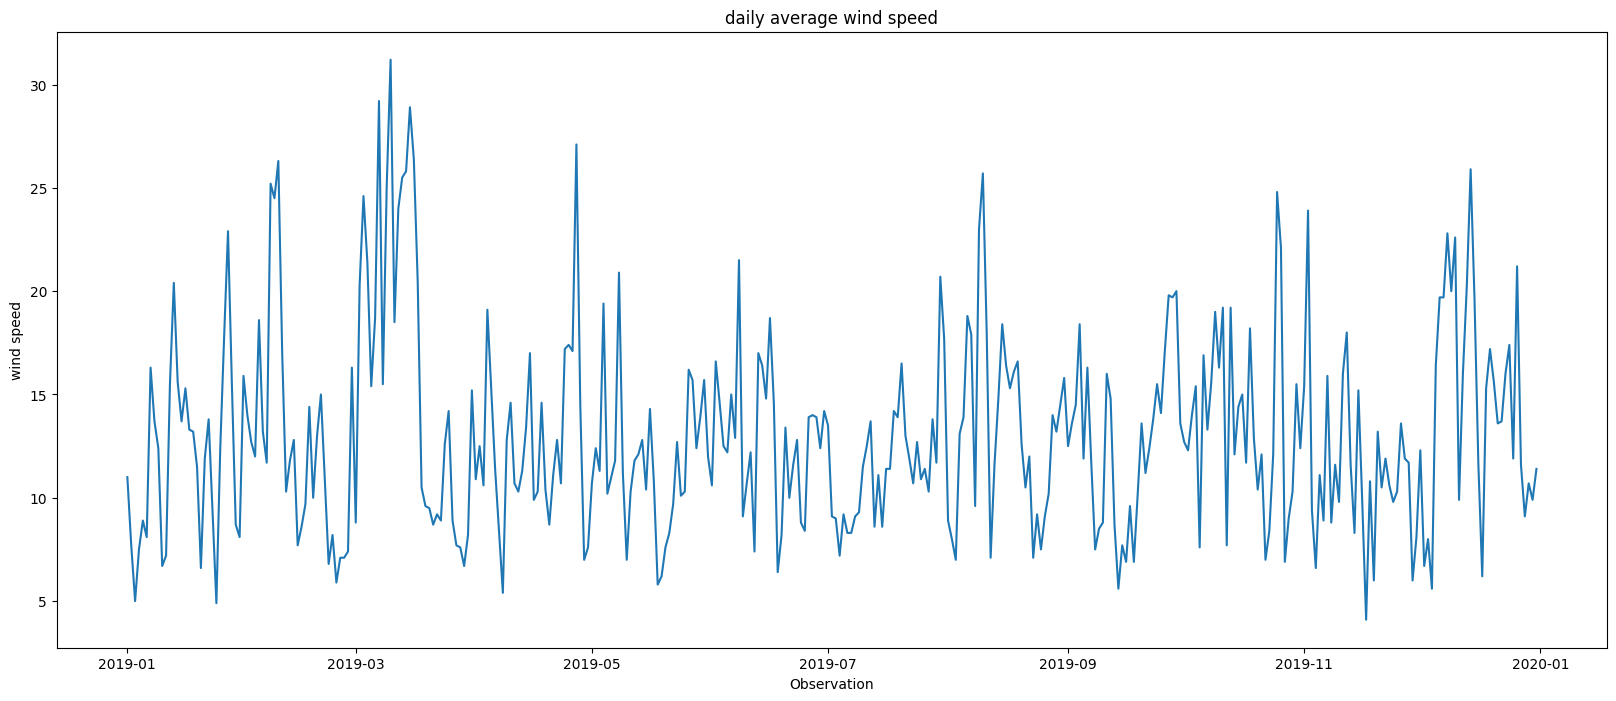

In [9]:
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(1, 1, 1)
ax.plot(wind_speed['datetime'][0:365],wind_speed['windspeed'][0:365])
ax.set_xlabel('Observation')
ax.set_ylabel('wind speed')
ax.set_title('daily average wind speed')

Text(0.5, 1.0, '-0.02178141804508097')

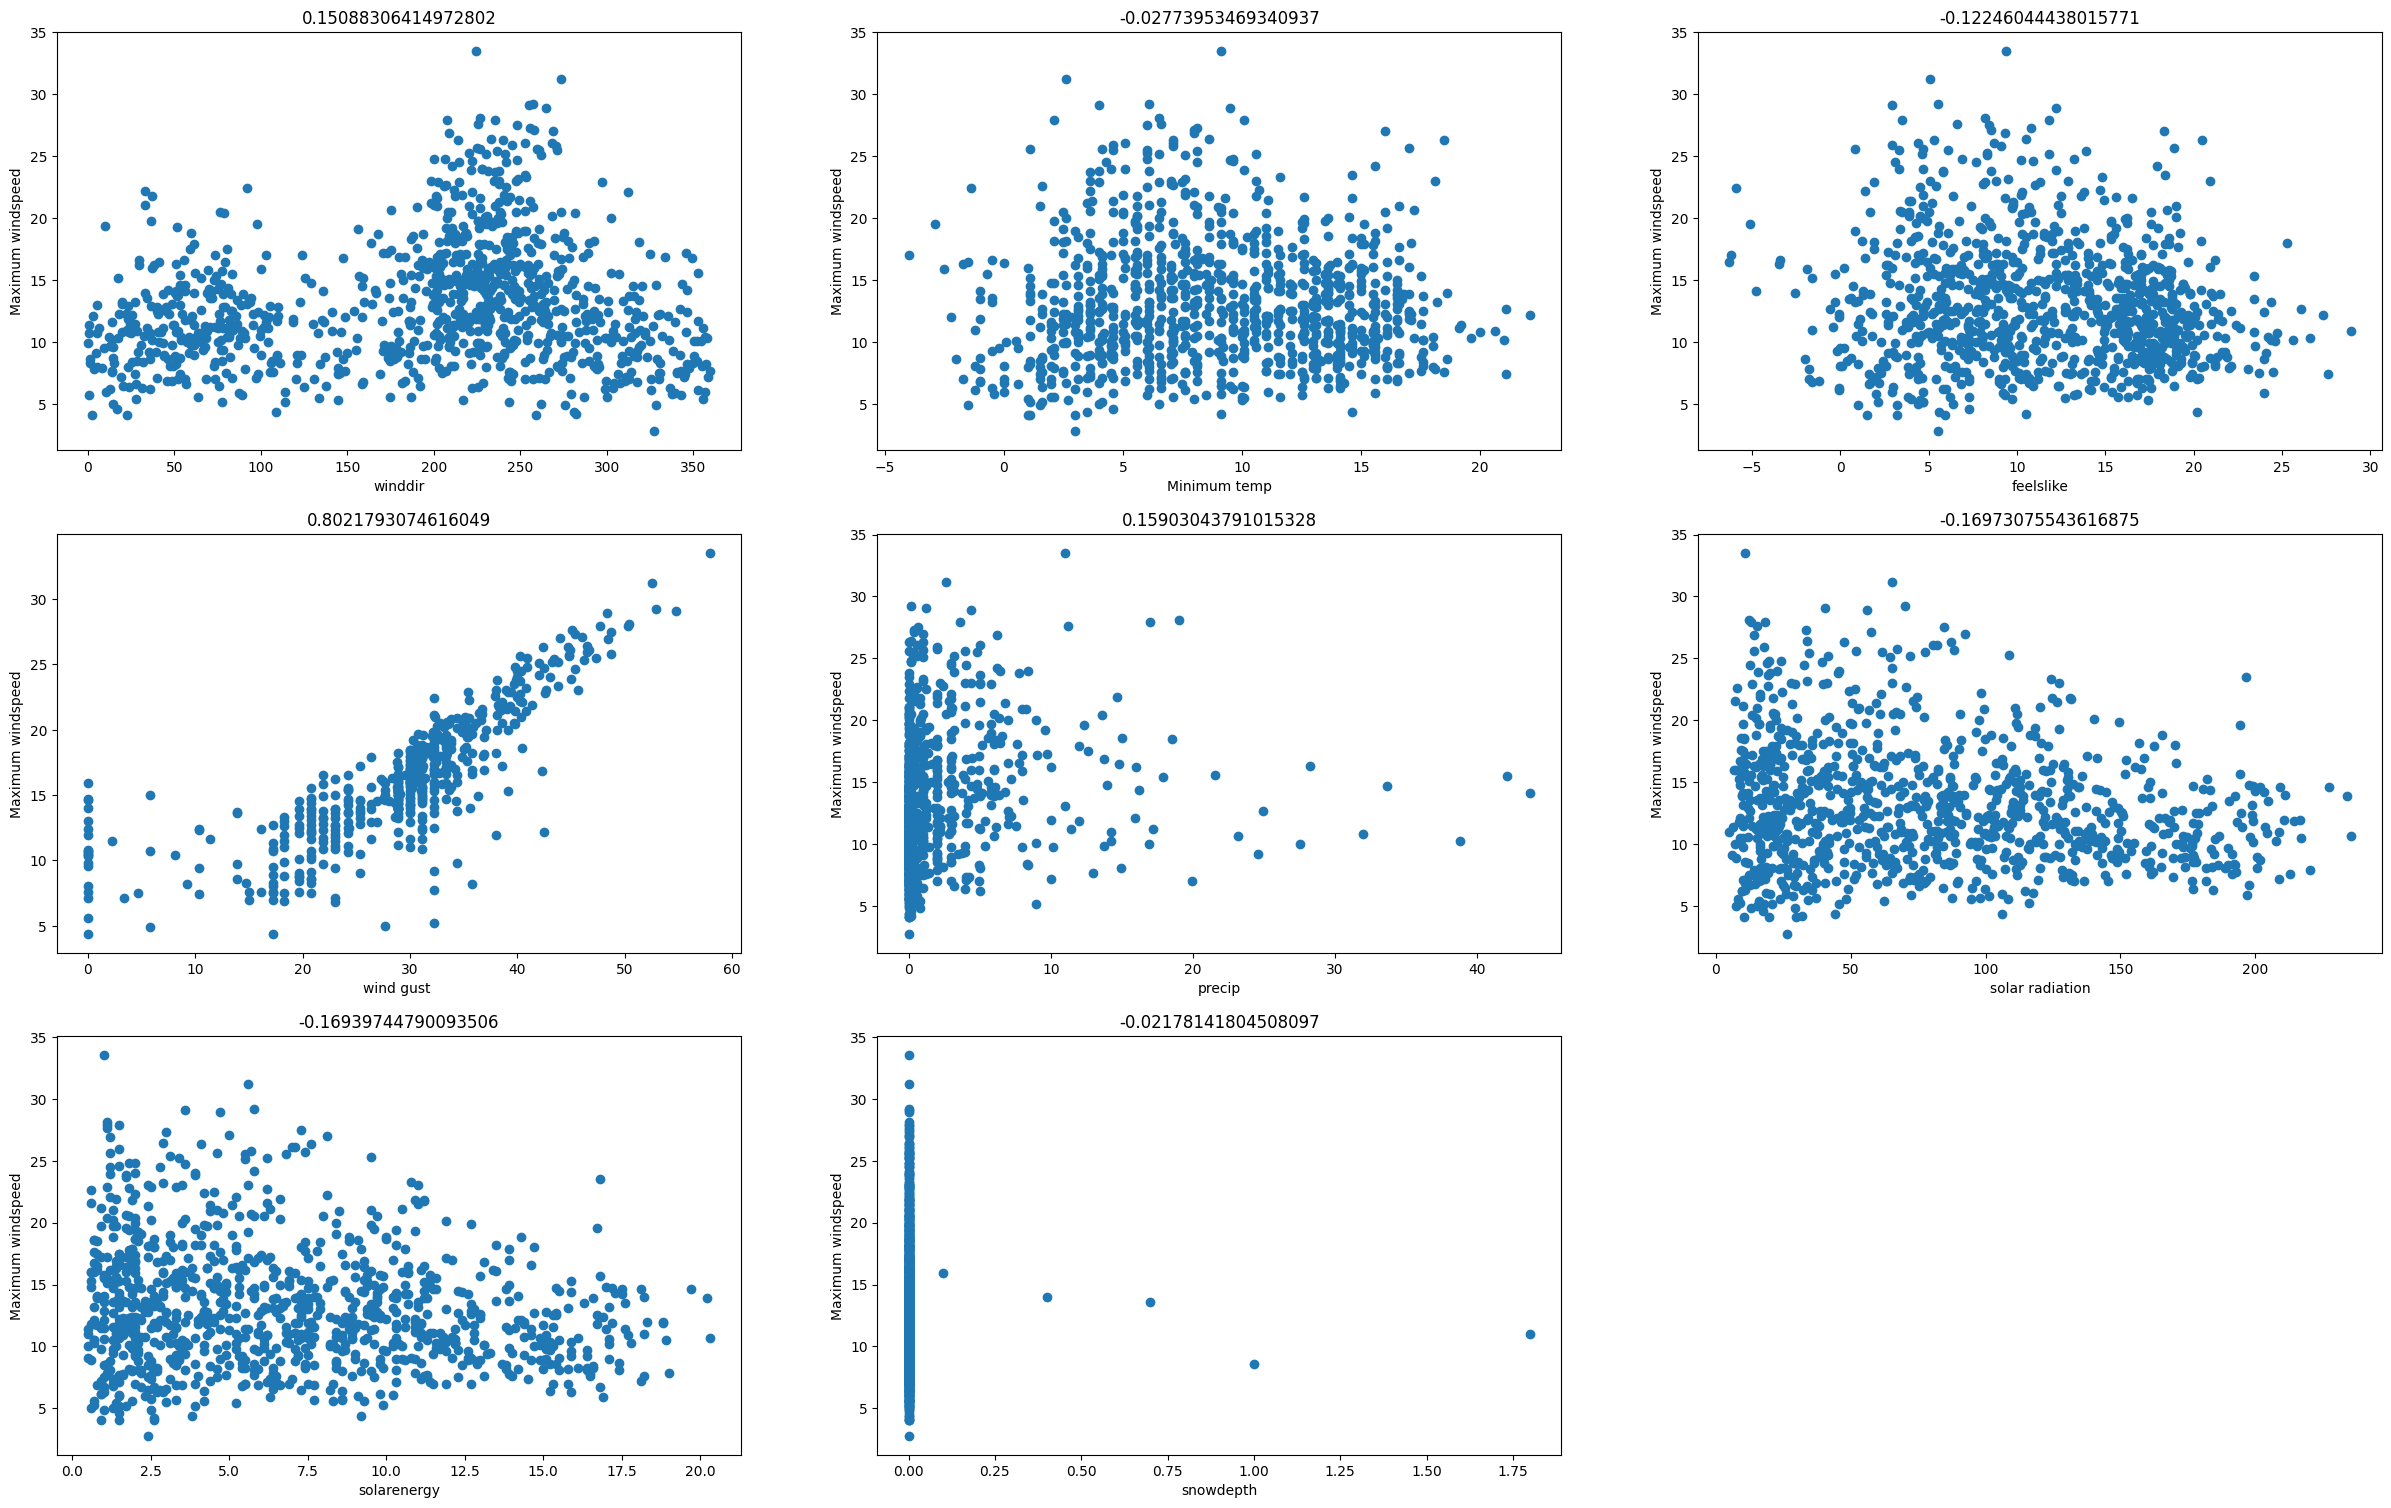

In [10]:
fig = plt.figure(figsize=[30, 25])
ax = fig.add_subplot(4, 3, 1)
ax.scatter(wind_speed['winddir'], wind_speed['windspeed'])
ax.set_xlabel('winddir')
ax.set_ylabel('Maximum windspeed')
ax.set_title(str(wind_speed['windspeed'].corr(wind_speed['winddir'])))

ax = fig.add_subplot(4, 3, 2)
ax.scatter(wind_speed['tempmin'], wind_speed['windspeed'])
ax.set_xlabel('Minimum temp')
ax.set_ylabel('Maximum windspeed')
ax.set_title(str(wind_speed['windspeed'].corr(wind_speed['tempmin'])))

ax = fig.add_subplot(4, 3, 3)
ax.scatter(wind_speed['feelslike'], wind_speed['windspeed'])
ax.set_xlabel('feelslike')
ax.set_ylabel('Maximum windspeed')
ax.set_title(str(wind_speed['windspeed'].corr(wind_speed['feelslike'])))

ax = fig.add_subplot(4, 3, 4)
ax.scatter(wind_speed['windgust'], wind_speed['windspeed'])
ax.set_xlabel('wind gust ')
ax.set_ylabel('Maximum windspeed')
ax.set_title(str(wind_speed['windspeed'].corr(wind_speed['windgust'])))

ax = fig.add_subplot(4, 3, 5)
ax.scatter(wind_speed['precip'], wind_speed['windspeed'])
ax.set_xlabel('precip')
ax.set_ylabel('Maximum windspeed')
ax.set_title(str(wind_speed['windspeed'].corr(wind_speed['precip'])))

ax = fig.add_subplot(4, 3, 6)
ax.scatter(wind_speed['solarradiation'], wind_speed['windspeed'])
ax.set_xlabel('solar radiation')
ax.set_ylabel('Maximum windspeed')
ax.set_title(str(wind_speed['windspeed'].corr(wind_speed['solarradiation'])))

ax = fig.add_subplot(4, 3, 7)
ax.scatter(wind_speed['solarenergy'], wind_speed['windspeed'])
ax.set_xlabel('solarenergy')
ax.set_ylabel('Maximum windspeed')
ax.set_title(str(wind_speed['windspeed'].corr(wind_speed['solarenergy'])))

ax = fig.add_subplot(4, 3, 8)
ax.scatter(wind_speed['snowdepth'], wind_speed['windspeed'])
ax.set_xlabel('snowdepth')
ax.set_ylabel('Maximum windspeed')
ax.set_title(str(wind_speed['windspeed'].corr(wind_speed['snowdepth'])))


Text(0.5, 1.0, '0.9997482617668604')

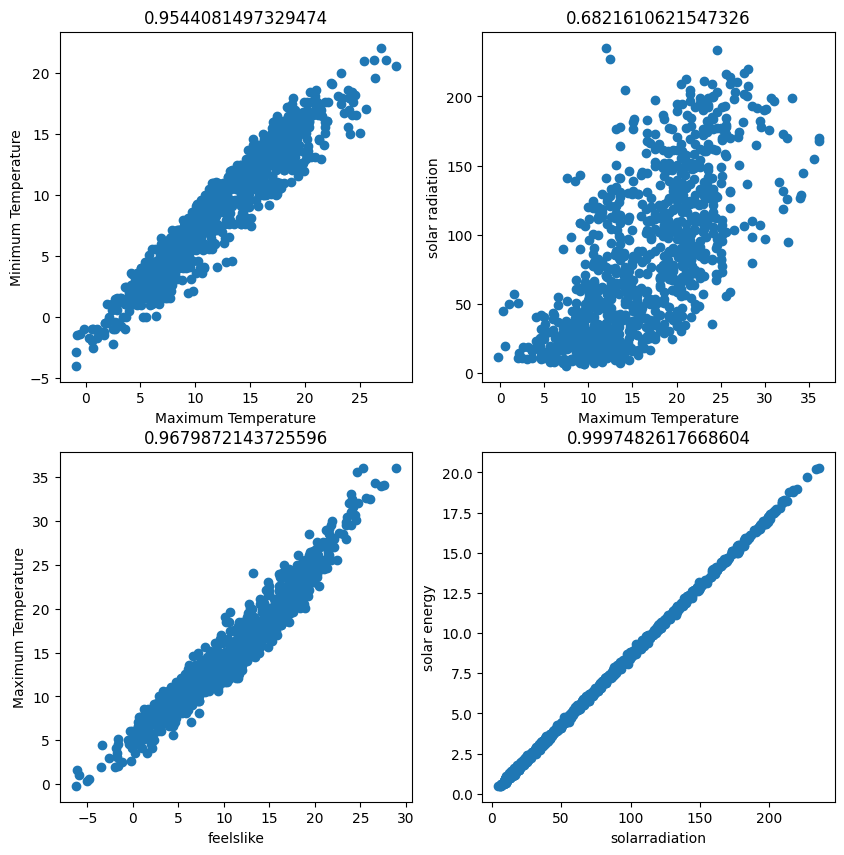

In [11]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(2, 2, 1)
ax.scatter(wind_speed['temp'], wind_speed['tempmin'])
ax.set_xlabel('Maximum Temperature')
ax.set_ylabel('Minimum Temperature')
ax.set_title(str(wind_speed['tempmin'].corr(wind_speed['temp'])))

ax = fig.add_subplot(2, 2, 2)
ax.scatter(wind_speed['tempmax'], wind_speed['solarradiation'])
ax.set_xlabel('Maximum Temperature')
ax.set_ylabel('solar radiation')
ax.set_title(str(wind_speed['solarradiation'].corr(wind_speed['tempmax'])))

ax = fig.add_subplot(2, 2, 3)
ax.scatter(wind_speed['feelslike'], wind_speed['tempmax'])
ax.set_xlabel('feelslike')
ax.set_ylabel('Maximum Temperature')
ax.set_title(str(wind_speed['tempmax'].corr(wind_speed['feelslike'])))

ax = fig.add_subplot(2, 2, 4)
ax.scatter(wind_speed['solarradiation'], wind_speed['solarenergy'])
ax.set_xlabel('solarradiation')
ax.set_ylabel('solar energy')
ax.set_title(str(wind_speed['solarradiation'].corr(wind_speed['solarenergy'])))

/var/folders/ck/7hlyx__x35qc46y2y16bktk80000gn/T/ipykernel_31929/2892719482.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(wind_speed.corr(), annot=True, cmap='coolwarm', fmt=".2f")


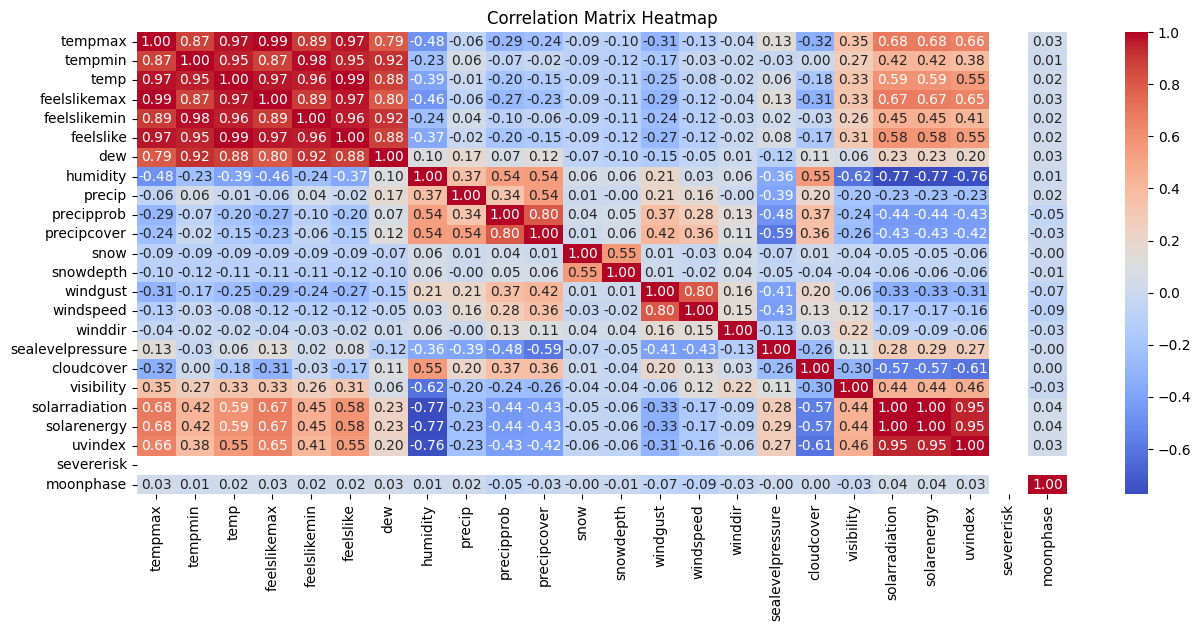

In [12]:
plt.figure(figsize=(15, 6))
sns.heatmap(wind_speed.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [13]:
columns_to_remove = ['windgust','humidity','precip','snow','dew','precipcover','sealevelpressure','moonphase','visibility','snowdepth','icon','precipprob','uvindex','cloudcover','name','datetime','severerisk', 'preciptype', 'sunrise', 'sunset', 'conditions', 'description', 'stations']
wind_speed = wind_speed.drop(columns = columns_to_remove)
wind_speed = wind_speed.dropna()
x = wind_speed.drop(columns = 'windspeed').to_numpy()
y = wind_speed['windspeed'].to_numpy().reshape(-1, 1)

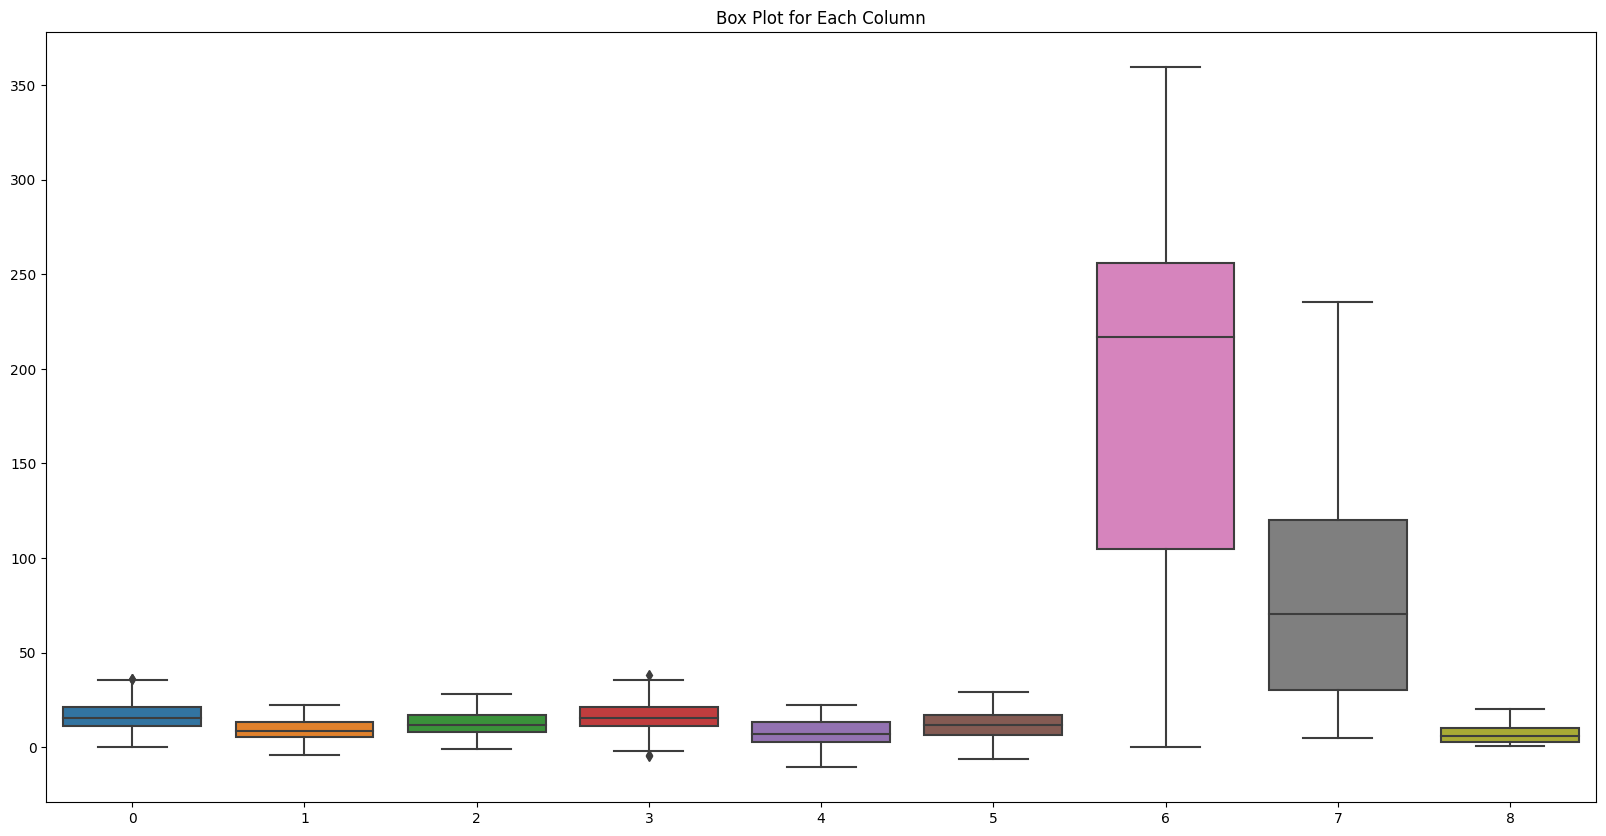

In [14]:
plt.figure(figsize=(20, 10))
sns.boxplot(data= x)
plt.title('Box Plot for Each Column')
plt.show()

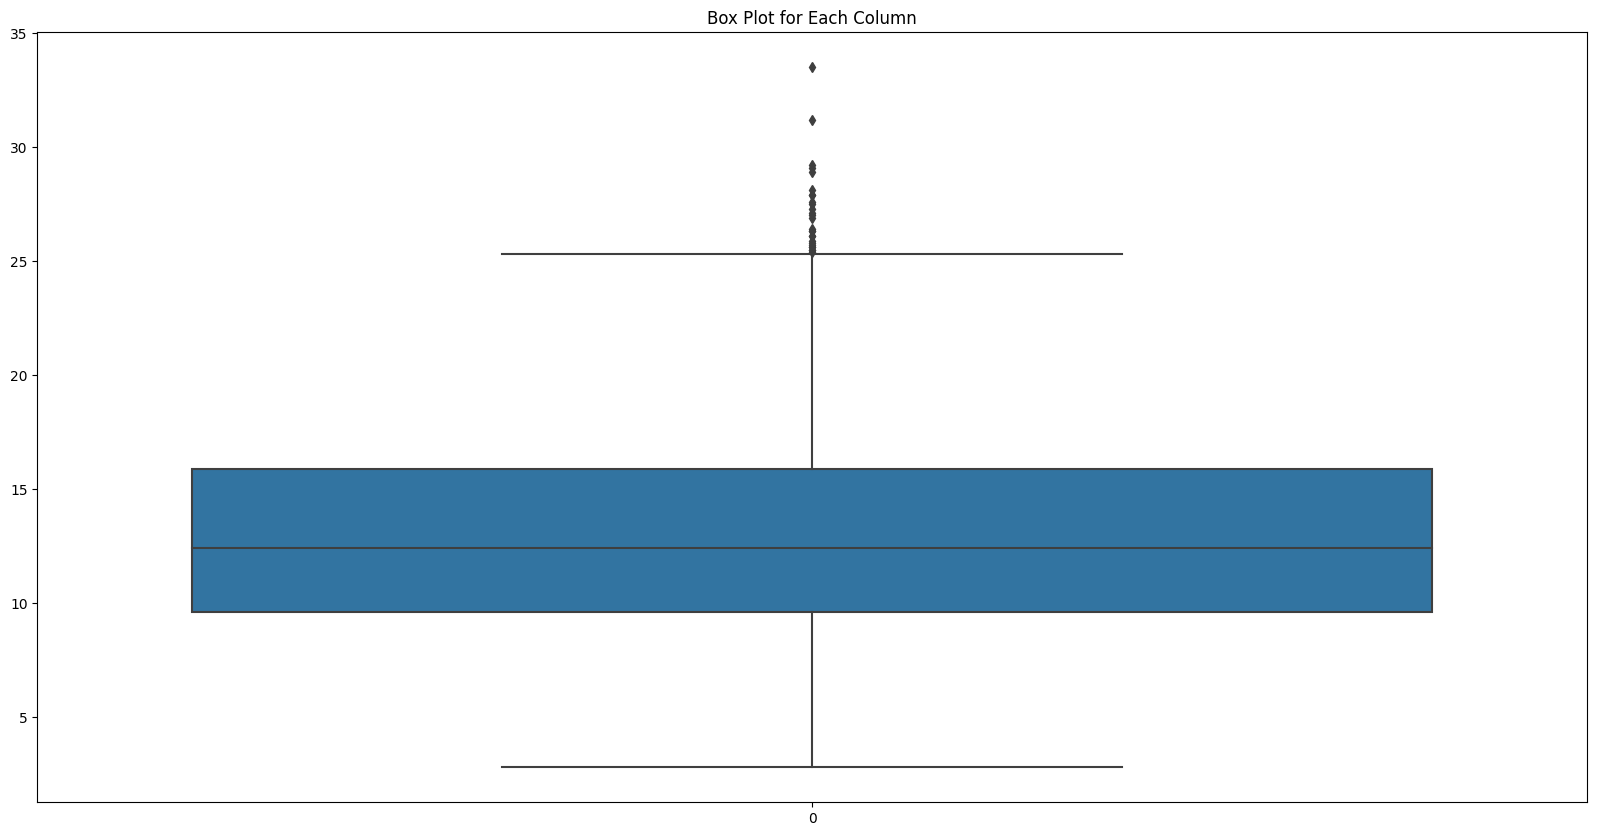

In [15]:
plt.figure(figsize=(20, 10))
sns.boxplot(data= y)
plt.title('Box Plot for Each Column')
plt.show()

In [39]:
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler().fit(x)
scaler_y = StandardScaler().fit(y)
x_train_stan = scaler_x.transform(x)
y_train_stan = scaler_y.transform(y)
lin_x_train = x_train_stan
lin_y_train_stan = y_train_stan  
lin_x_train_stan = sm.add_constant(lin_x_train)    
lin_x_train_stan.shape

(1000, 10)

In [40]:
train_samples = int(len(x_train_stan)*0.6)
val_samples = int(len(x_train_stan) * 0.2)

x_train = x_train_stan[:train_samples, :]
y_train = y_train_stan[:train_samples]
x_val = x_train_stan[train_samples:(train_samples + val_samples), :]
y_val = y_train_stan[train_samples:(train_samples + val_samples)]
x_test = x_train_stan[(train_samples + val_samples):, :]
y_test = y_train_stan[(train_samples + val_samples):]

lin_train_samples = int(len(lin_x_train_stan)*0.6)
lin_val_samples = int(len(lin_y_train_stan) * 0.2)
lin_x_train = lin_x_train_stan[:lin_train_samples, :]
lin_y_train = lin_y_train_stan[:lin_train_samples]
lin_x_val = lin_x_train_stan[lin_train_samples:(lin_train_samples + lin_val_samples), :]
lin_y_val = lin_y_train_stan[lin_train_samples:(lin_train_samples + lin_val_samples)]
lin_x_test = lin_x_train_stan[(lin_train_samples + lin_val_samples):, :]
lin_y_test = lin_y_train_stan[(lin_train_samples + lin_val_samples):]

print(x_train.shape)
print(lin_x_train.shape)

(600, 9)
(600, 10)


In [41]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(600, 9)
(600, 1)
(200, 9)
(200, 1)
(200, 9)
(200, 1)


In [42]:
print(lin_x_train.shape)
print(lin_y_train.shape)
print(lin_x_val.shape)
print(lin_y_val.shape)
print(lin_x_test.shape)
print(lin_y_test.shape)

(600, 10)
(600, 1)
(200, 10)
(200, 1)
(200, 10)
(200, 1)


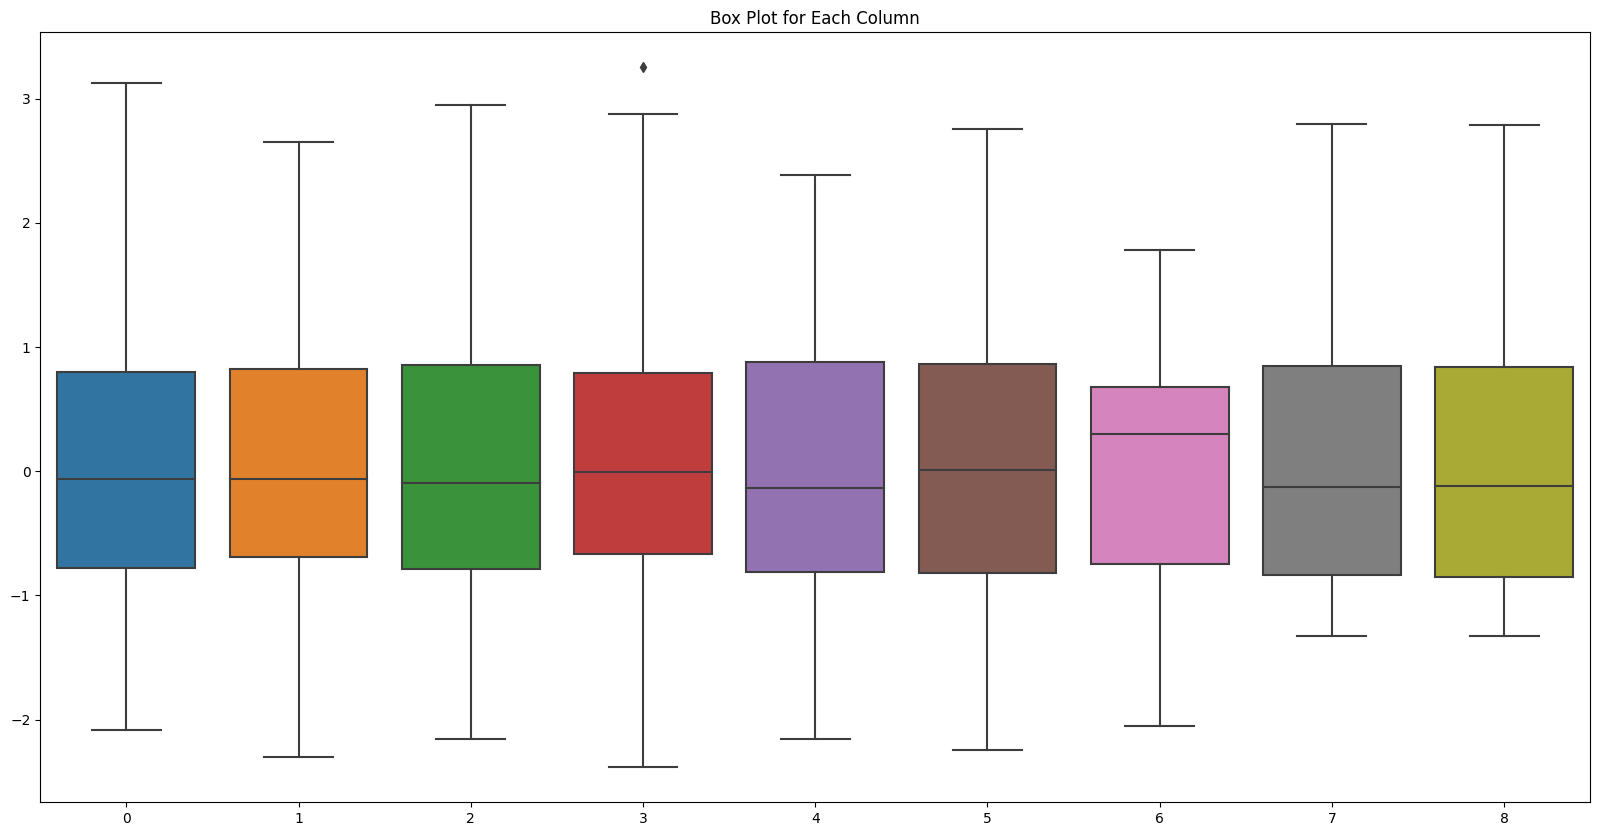

In [43]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=x_train)
plt.title('Box Plot for Each Column')
plt.show()

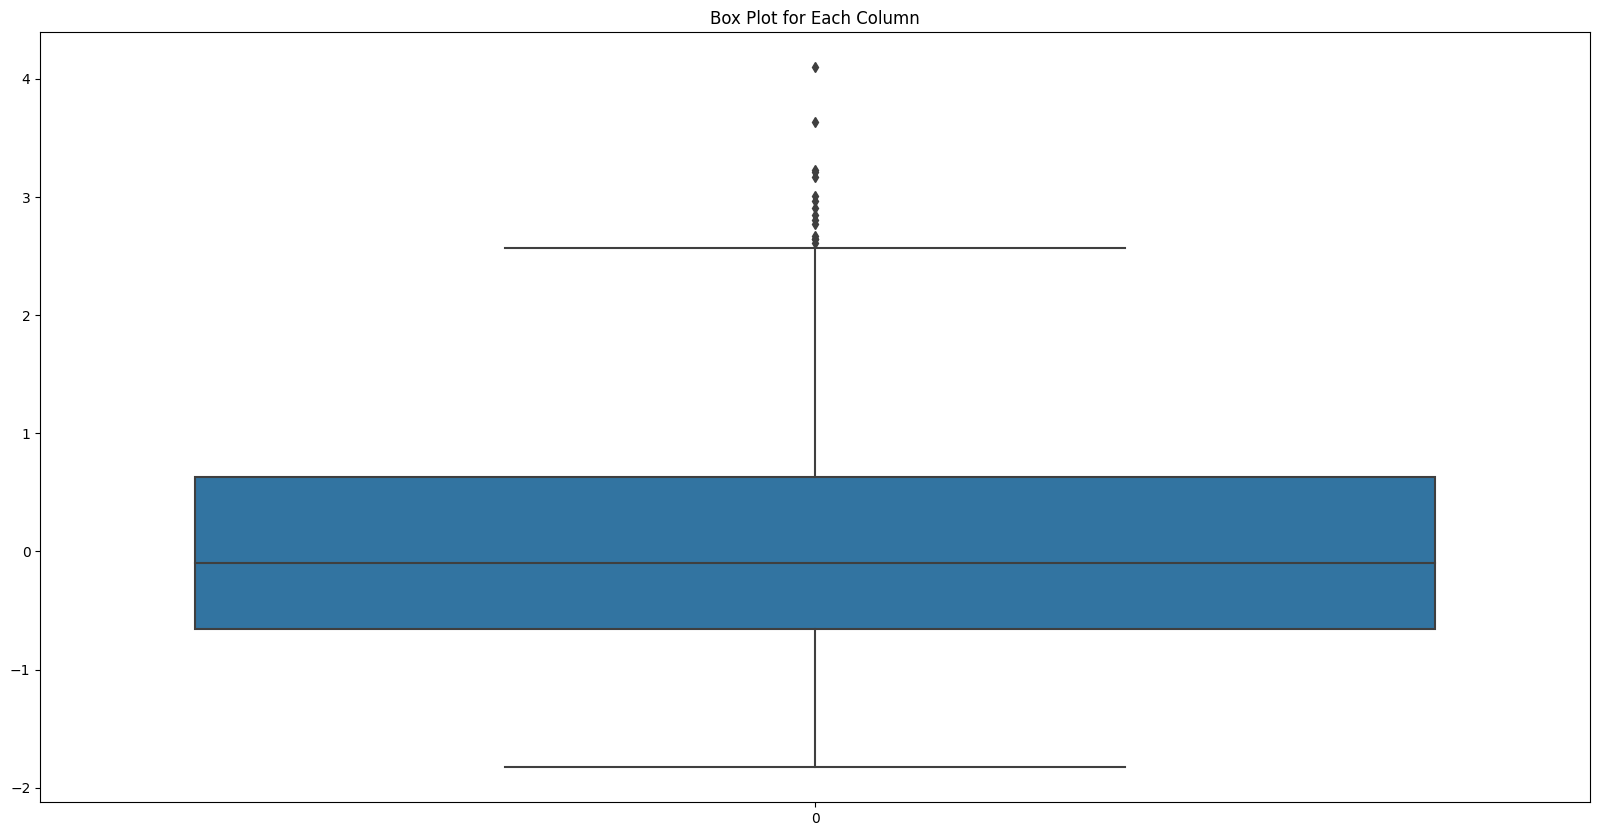

In [44]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=y_train)
plt.title('Box Plot for Each Column')
plt.show()

In [45]:
# Function to create sequences for time series forecasting
def create_sequences(data, target, time_steps=1):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(x), np.array(y)

# Define the number of time steps
time_steps = 1

# Create sequences for training data
x_train_seq, y_train_seq = create_sequences(np.array(x_train), np.array(y_train), time_steps)

x_val_seq, y_val_seq = create_sequences(np.array(x_val), np.array(y_val), time_steps)

# Create sequences for test data
x_test_seq, y_test_seq = create_sequences(np.array(x_test), np.array(y_test), time_steps)

# Reshape the data for compatibility with neural networks
x_train_seq = x_train_seq.reshape((x_train_seq.shape[0], 1, x_train_seq.shape[2]))
x_test_seq = x_test_seq.reshape((x_test_seq.shape[0], 1, x_test_seq.shape[2]))
x_val_seq = x_val_seq.reshape((x_val_seq.shape[0], 1, x_val_seq.shape[2]))

In [46]:
print(x_test_seq.shape)
print(y_test_seq.shape)

(199, 1, 9)
(199, 1)


In [47]:
tf.random.set_seed(7)

In [48]:
model = Sequential()
model.add(Bidirectional(LSTM(8, return_sequences=True), input_shape=(time_steps, 9)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(16, return_sequences=False)))
model.add(BatchNormalization())
model.compile(loss='mean_squared_error', optimizer='adam')
model.add(Dense(1))


#Train the model
history = model.fit(x_train_seq, y_train_seq, epochs=50, batch_size=8, validation_data= [x_val_seq, y_val_seq])

2024-04-26 17:37:06.830377: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
75/75 [==============================] - 6s 17ms/step - loss: 1.5220 - val_loss: 1.0105
Epoch 2/50
75/75 [==============================] - 0s 3ms/step - loss: 1.0893 - val_loss: 1.0182
Epoch 3/50
75/75 [==============================] - 0s 3ms/step - loss: 0.9868 - val_loss: 1.0182
Epoch 4/50
75/75 [==============================] - 0s 3ms/step - loss: 1.0163 - val_loss: 1.0135
Epoch 5/50
75/75 [==============================] - 0s 3ms/step - loss: 1.0336 - val_loss: 0.9577
Epoch 6/50
75/75 [==============================] - 0s 3ms/step - loss: 0.9933 - val_loss: 0.9074
Epoch 7/50
75/75 [==============================] - 0s 3ms/step - loss: 0.9309 - val_loss: 0.9679
Epoch 8/50
75/75 [==============================] - 0s 3ms/step - loss: 0.9579 - val_loss: 0.9624
Epoch 9/50
75/75 [==============================] - 0s 3ms/step - loss: 0.9559 - val_loss: 0.9702
Epoch 10/50
75/75 [==============================] - 0s 3ms/step - loss: 0.9675 - val_loss: 1.3857
Epoch 11/50
75/75 

In [51]:
pred_1 = model.predict(x_test_seq)
pred_1 = scaler_y.inverse_transform(pred_1)

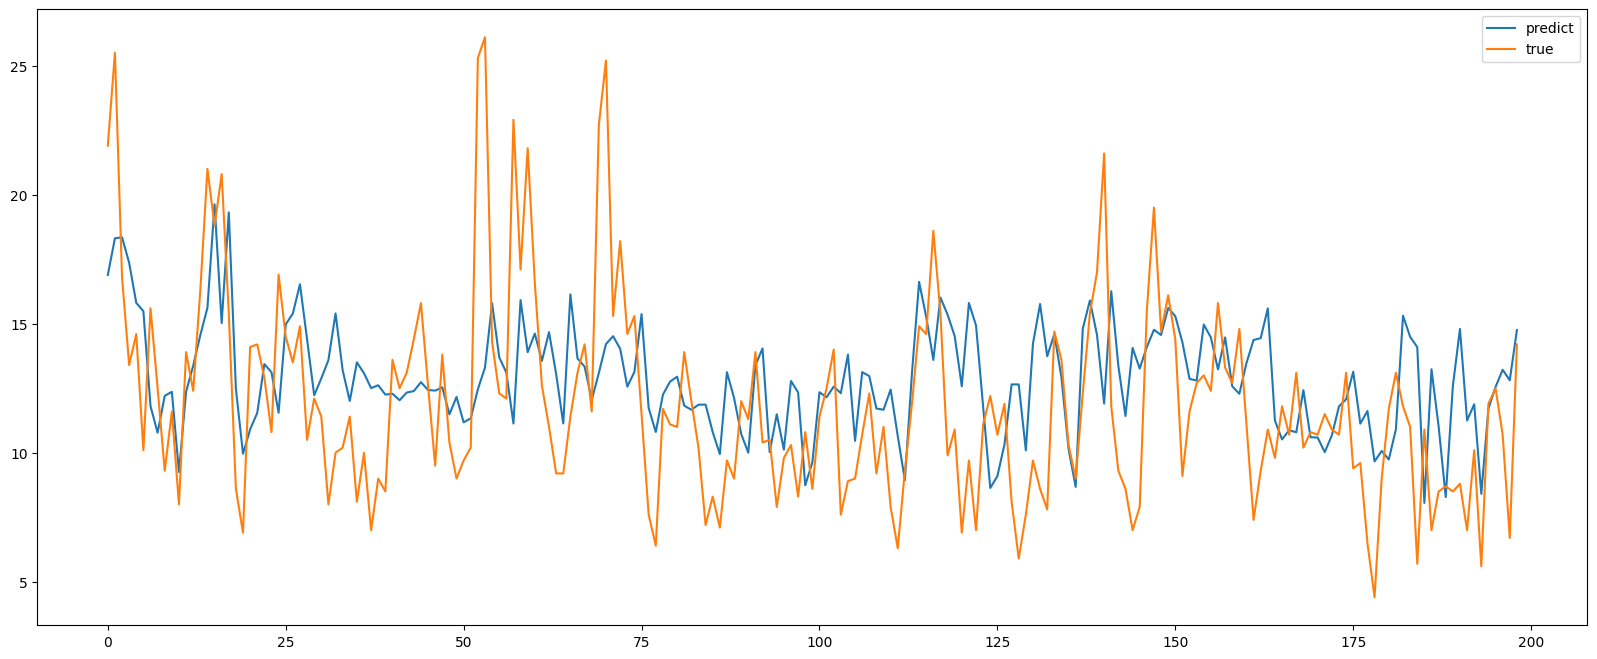

In [52]:
plt.figure(figsize=(20,8))
plt.plot(pred_1, label='predict')
plt.plot(scaler_y.inverse_transform(y_test_seq), label='true')
plt.legend()
plt.show()

In [85]:
lstm_mse = mean_squared_error(scaler_y.inverse_transform(y_test_seq), pred_1)
lstm_rsquared = r2_score(scaler_y.inverse_transform(y_test_seq), pred_1)
lstm_rsme = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test_seq), pred_1))


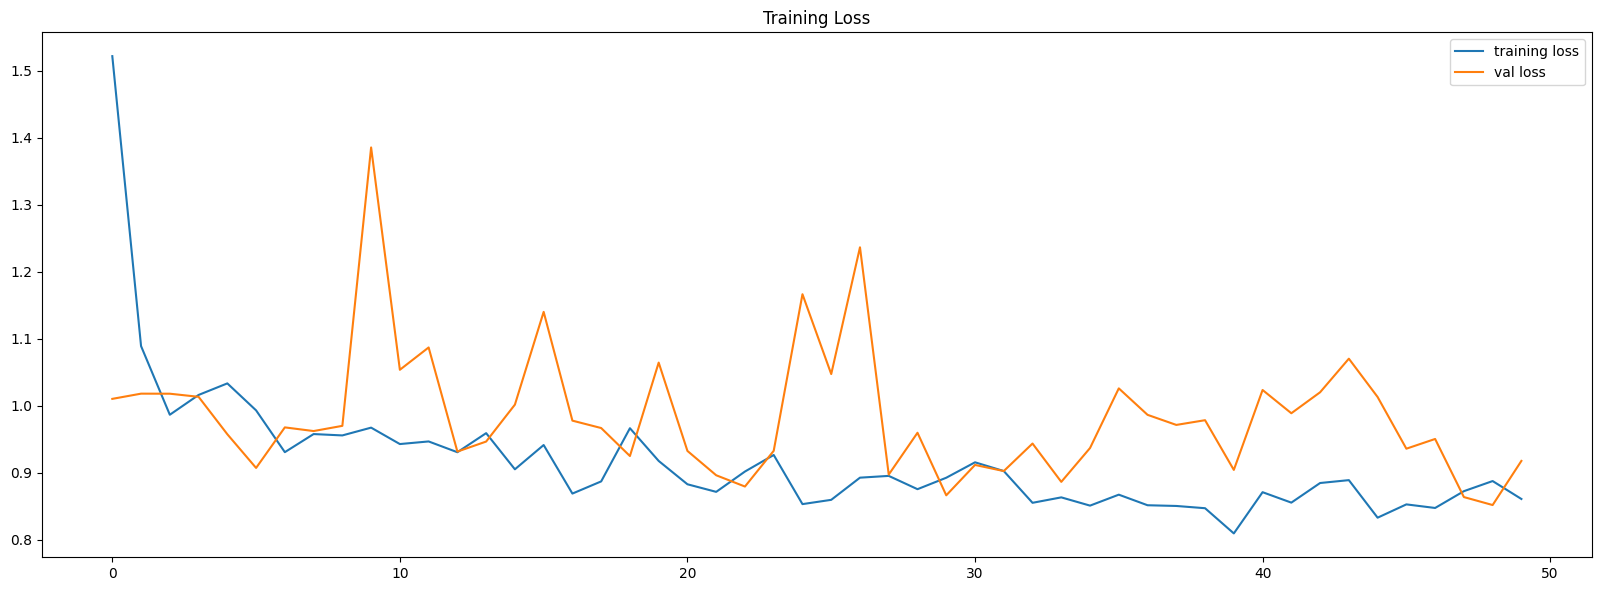

In [54]:
fig = plt.figure(figsize=[20, 15])
ax = fig.add_subplot(2, 1, 1)
ax.plot(history.history['loss'], label="training loss")
ax.plot(history.history['val_loss'], label="val loss")
ax.plot
plt.title('Training Loss')
ax.legend()

In [ ]:
loss = history.history['mae']
val_loss = history.history['val_mae']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Accuracy')
plt.plot(epochs, val_loss, label='Validation Accuracy')
plt.title('Accuracy and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

In [ ]:
x_train.info

In [82]:
linear_model = sm.OLS(lin_y_train, lin_x_train)
trained_model = linear_model.fit()


pred = trained_model.predict(lin_x_test)
pred = scaler_y.inverse_transform(pred.reshape(-1, 1))
mse_val = mean_squared_error(scaler_y.inverse_transform(lin_y_test.reshape(-1, 1)), pred)
r2 = r2_score(scaler_y.inverse_transform(lin_y_test.reshape(-1, 1)), pred)
rmse_lin = np.sqrt(mean_squared_error(scaler_y.inverse_transform(lin_y_test.reshape(-1, 1)), pred))

print("Model mean squared error = {}".format(np.sqrt(mse_val)))
print("R-Squared = {}".format(r2))
print("Real mean squared error = {}".format(rmse_lin))
print(trained_model.summary())

Model mean squared error = 3.8653760482769473
R-Squared = 0.10962270620263426
Real mean squared error = 3.8653760482769473
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     40.03
Date:                Fri, 26 Apr 2024   Prob (F-statistic):           1.14e-55
Time:                        21:36:42   Log-Likelihood:                -732.85
No. Observations:                 600   AIC:                             1486.
Df Residuals:                     590   BIC:                             1530.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------

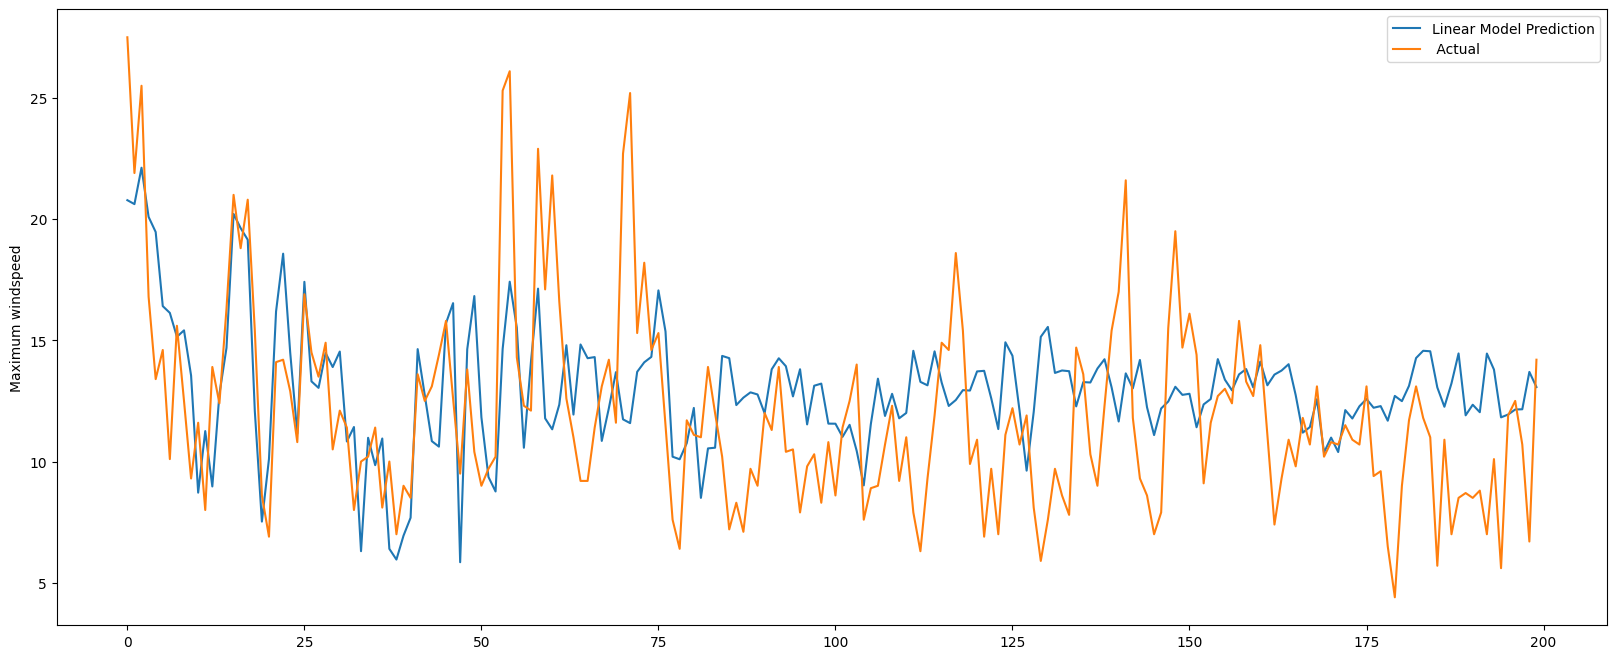

In [83]:
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(1, 1, 1)
ax.plot(pred,label="Linear Model Prediction")
ax.plot(scaler_y.inverse_transform(lin_y_test.reshape(-1, 1)),label = " Actual ")
ax.set_ylabel('Maximum windspeed')
ax.legend();

In [ ]:
pip install pmdarima

In [65]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

<Figure size 1000x500 with 0 Axes>

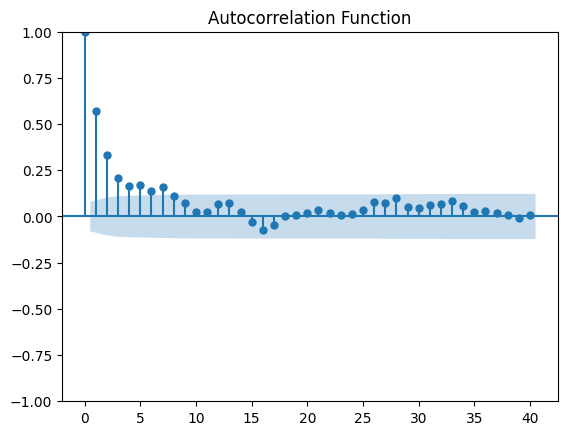

In [66]:
plt.figure(figsize=(10, 5))
plot_acf(y_train, lags=40)  # Adjust 'y_train' to the name of your dataset and 'lags' as needed
plt.title('Autocorrelation Function')
plt.show()

/Users/ebz/miniconda3/envs/tf/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1000x500 with 0 Axes>

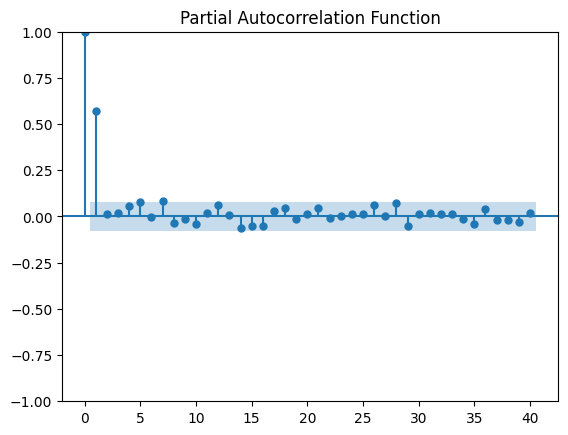

In [67]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

# Replace 'your_time_series_data' with your actual time series variable name
plt.figure(figsize=(10, 5))
plot_pacf(y_train, lags=40)  # Adjust lags as needed for your dataset
plt.title('Partial Autocorrelation Function')
plt.show()

In [68]:
arima_model = ARIMA(y_train, order=(2, 0, 1))
arima_model_fit = arima_model.fit()
arima_model_fit_summary = arima_model_fit.summary()

print(arima_model_fit_summary)

/Users/ebz/miniconda3/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ebz/miniconda3/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  600
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -756.421
Date:                Fri, 26 Apr 2024   AIC                           1522.843
Time:                        17:40:47   BIC                           1544.827
Sample:                             0   HQIC                          1531.401
                                - 600                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0868      0.112      0.772      0.440      -0.134       0.307
ar.L1          1.3727      0.186      7.368      0.000       1.008       1.738
ar.L2         -0.4307      0.120     -3.584      0.0

In [75]:
start = len(y_train)  
end = start + len(x_test) - 1  # Predict up to the end of the 'x_test' dataset

# Generate predictions
predictions = arima_model_fit.predict(start=start, end=end)
predictions = scaler_y.inverse_transform(predictions.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test), predictions))
mse = mean_squared_error(scaler_y.inverse_transform(y_test), predictions)
rsquare = r2_score(scaler_y.inverse_transform(y_test), predictions)
  
# Calculate mean squared error 
#mean_squared_error(y_train, predictions)

In [76]:
print(rmse)
print(mse)
print(rsquare)

4.3041602059458866
18.525795078448137
-0.10399582129134477


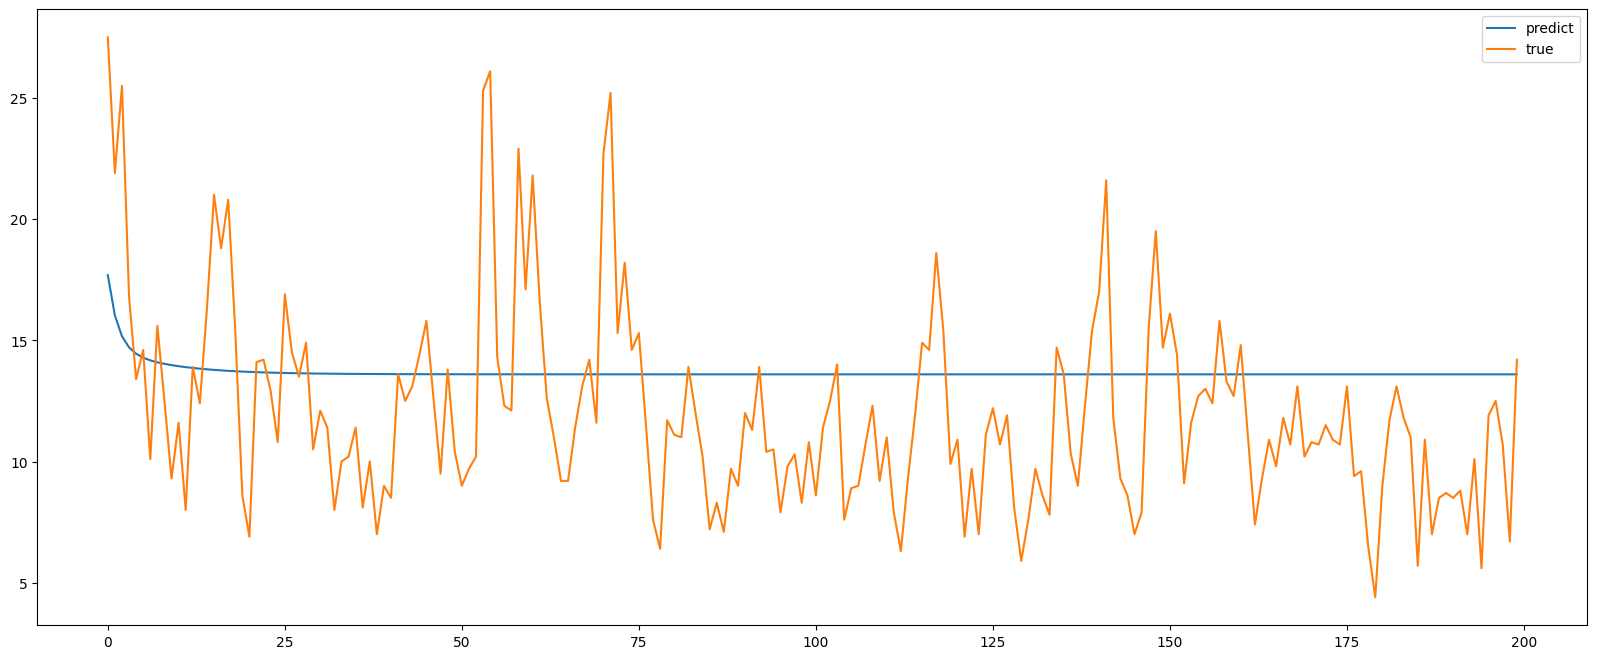

In [77]:

plt.figure(figsize=(20,8))
plt.plot(predictions, label='predict')
plt.plot(scaler_y.inverse_transform(y_test), label='true')
plt.legend()
plt.show()

In [87]:
data = {
    "Model": ["Linear Regression", "LSTM", "ARIMA"],
    "RMSE": [rmse_lin, lstm_rsme, rmse],
    "MSE": [mse_val, lstm_mse, mse],
    "R-squared": [r2, lstm_rsquared, rsquare]
}

df = pd.DataFrame(data)
df

,Model,RMSE,MSE,R-squared
0,Linear Regression,3.865376,14.941132,0.109623
1,LSTM,3.785387,14.329155,0.084450
2,ARIMA,4.304160,18.525795,-0.103996
